[Episodio 0] Passi attaccati: pos=0, ang=0, entrambi=0


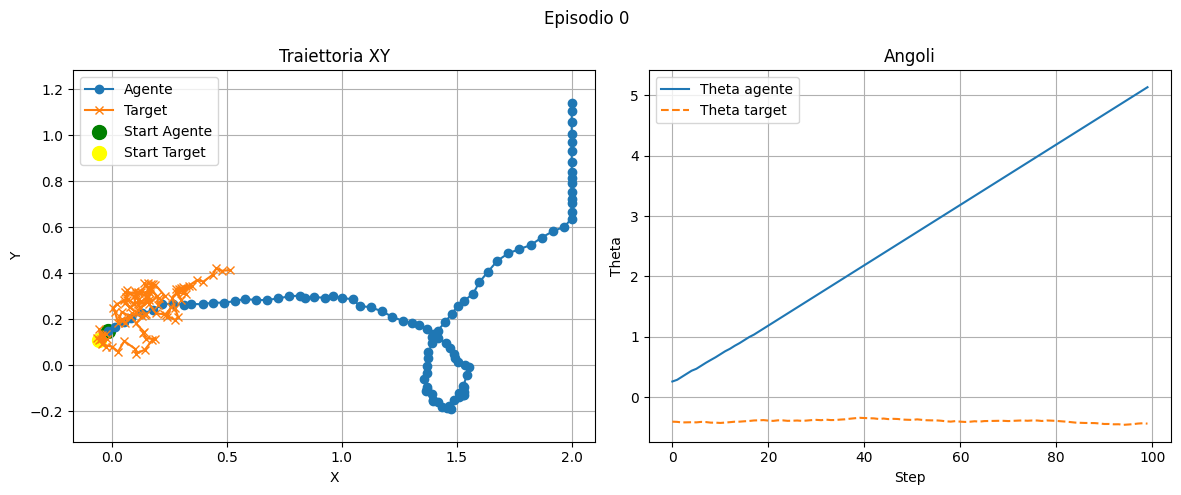

[Episodio 1] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 2] Passi attaccati: pos=1, ang=1, entrambi=0
[Episodio 3] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 4] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 5] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 6] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 7] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 8] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 9] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 10] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 11] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 12] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 13] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 14] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 15] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 16] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 17] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 18] Passi attaccati: pos=0, ang=1, entrambi=0
[

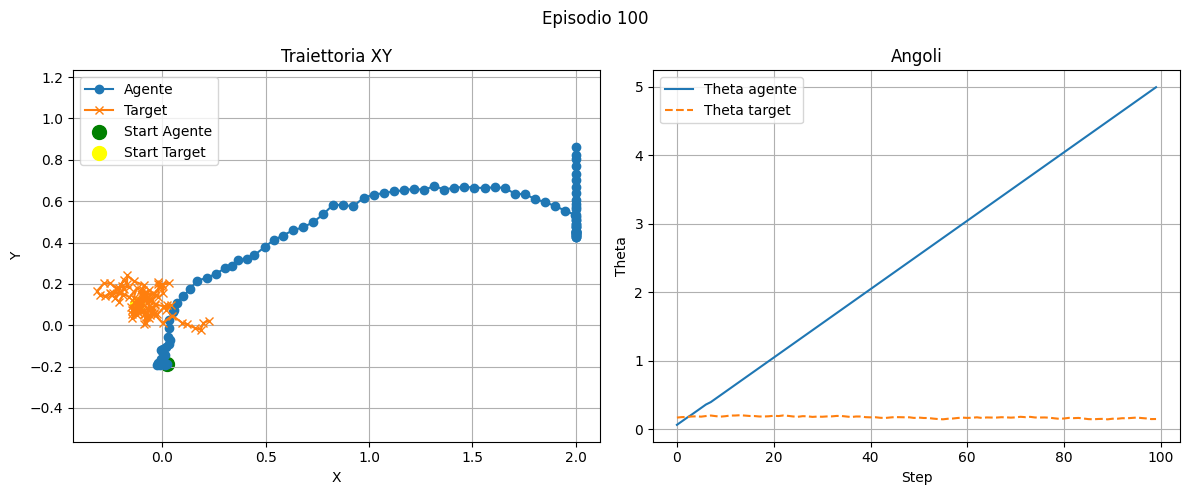

[Episodio 101] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 102] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 103] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 104] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 105] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 106] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 107] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 108] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 109] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 110] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 111] Passi attaccati: pos=1, ang=1, entrambi=0
[Episodio 112] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 113] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 114] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 115] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 116] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 117] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 118] Passi attaccati:

KeyboardInterrupt: 

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from rototransl_env import TrackingEnv
from gail_transl import GaussianPolicy

def load_gail_policy(path="IL/gail_policy.pth"):
    model = GaussianPolicy(obs_dim=6, act_dim=3)
    model.load_state_dict(torch.load(path, map_location=torch.device("cpu")))
    model.eval()
    return model

def test_gail_policy(model, num_episodes=1000, tolerance_transl=0.02, tolerance_rot=0.01):
    env = TrackingEnv()
    
    total_attached = 0
    total_attached_transl = 0
    total_attached_rot = 0
    final_distances = []
    final_angle_errors = []

    for ep in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32)

        trajectory = []
        target_traj = []
        theta_traj = []
        theta_target_traj = []

        done = False
        total_attached_ep = 0
        total_attached_transl_ep = 0
        total_attached_rot_ep = 0

        while not done:
            trajectory.append(state[:2].numpy())
            target_traj.append(state[3:5].numpy())
            theta_traj.append(state[2].item())
            theta_target_traj.append(state[5].item())

            obs = state.unsqueeze(0)
            with torch.no_grad():
                dist = model(obs)  # restituisce una distribuzione
                action = dist.sample().squeeze(0).numpy()

            action = np.clip(action, env.action_space.low, env.action_space.high)

            next_state, _, done, truncated, _, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32)

            dist_transl = torch.norm(next_state[:2] - state[3:5])
            dist_rot = torch.abs(next_state[2] - state[5])

            if dist_transl < tolerance_transl:
                total_attached_transl_ep += 1
            if dist_rot < tolerance_rot:
                total_attached_rot_ep += 1
            if dist_transl < tolerance_transl and dist_rot < tolerance_rot:
                total_attached_ep += 1

            state = next_state
            done = truncated

        final_distances.append(dist_transl.item())
        final_angle_errors.append(dist_rot.item())
        total_attached += total_attached_ep
        total_attached_transl += total_attached_transl_ep
        total_attached_rot += total_attached_rot_ep

        print(f"[Episodio {ep}] Passi attaccati: pos={total_attached_transl_ep}, ang={total_attached_rot_ep}, entrambi={total_attached_ep}")
        if ep % 100 == 0:
            plot_trajectory(trajectory, target_traj, theta_traj, theta_target_traj, ep)

    env.close()

    print("\nRisultati aggregati:")
    print(f"Media passi attaccati (traslazione): {total_attached_transl / num_episodes:.2f}")
    print(f"Media passi attaccati (rotazione):    {total_attached_rot / num_episodes:.2f}")
    print(f"Media passi attaccati (entrambi):     {total_attached / num_episodes:.2f}")
    print(f"Distanza media finale:                {np.mean(final_distances):.4f}")
    print(f"Errore medio angolo finale:           {np.mean(final_angle_errors):.4f}")

def plot_trajectory(trajectory, target_traj, theta_traj, theta_target_traj, episode):
    trajectory = np.array(trajectory)
    target_traj = np.array(target_traj)
    theta_traj = np.array(theta_traj)
    theta_target_traj = np.array(theta_target_traj)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(trajectory[:, 0], trajectory[:, 1], marker='o', label="Agente")
    axs[0].plot(target_traj[:, 0], target_traj[:, 1], marker='x', label="Target")
    axs[0].scatter(trajectory[0, 0], trajectory[0, 1], color='green', label='Start Agente', s=100)
    axs[0].scatter(target_traj[0, 0], target_traj[0, 1], color='yellow', label='Start Target', s=100)
    axs[0].set_title("Traiettoria XY")
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].legend()
    axs[0].grid(True)
    axs[0].axis('equal')

    axs[1].plot(theta_traj, label="Theta agente")
    axs[1].plot(theta_target_traj, label="Theta target", linestyle='--')
    axs[1].set_title("Angoli")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("Theta")
    axs[1].legend()
    axs[1].grid(True)

    plt.suptitle(f"Episodio {episode}")
    plt.tight_layout()
    plt.show()
    plt.close()

# --- MAIN ---
if __name__ == "__main__":
    policy = load_gail_policy("IL/gail_policy.pth")
    test_gail_policy(policy, num_episodes=1000)


[Episodio 0] Passi attaccati: pos=0, ang=0, entrambi=0


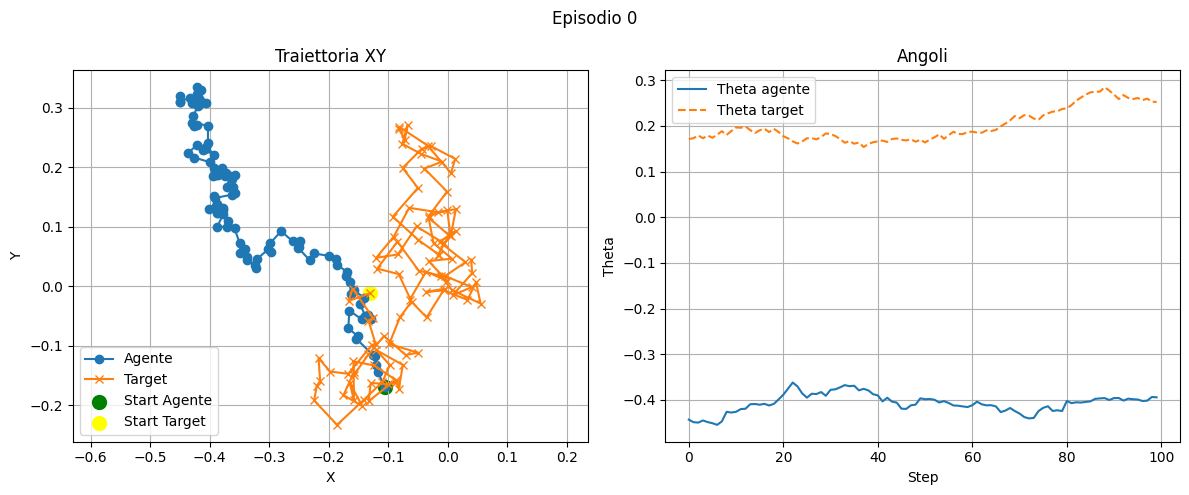

[Episodio 1] Passi attaccati: pos=1, ang=0, entrambi=0


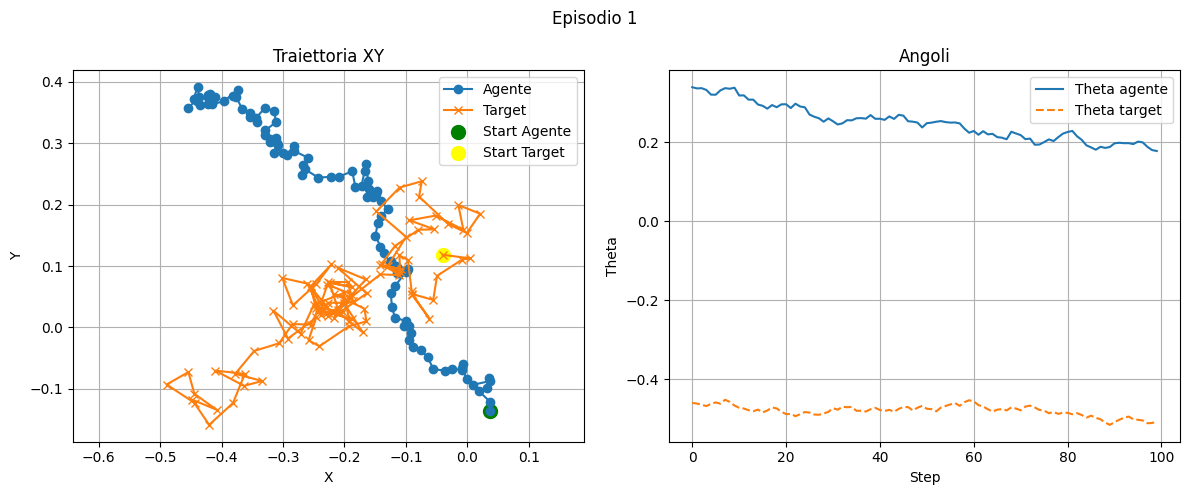

[Episodio 2] Passi attaccati: pos=0, ang=0, entrambi=0


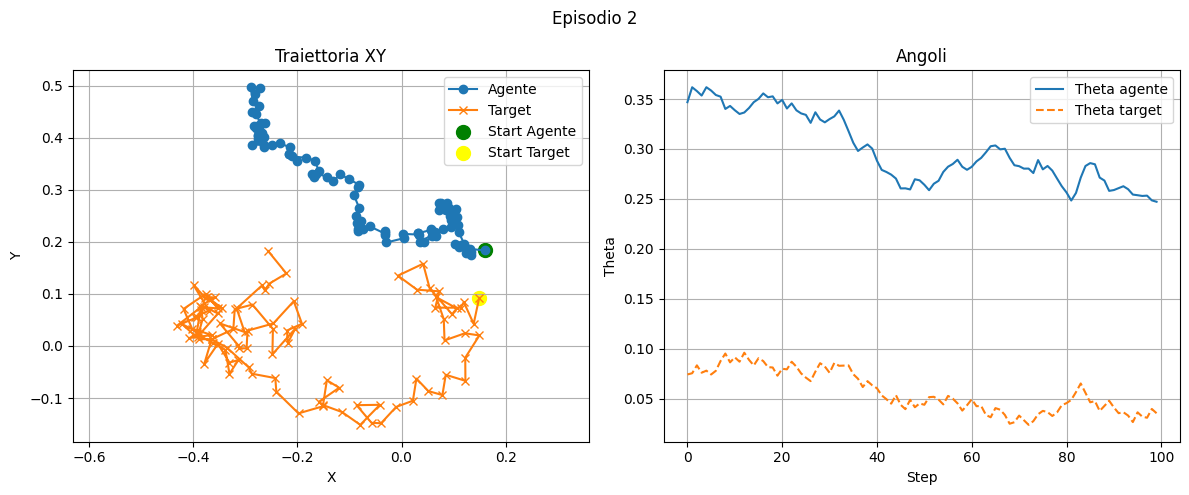

[Episodio 3] Passi attaccati: pos=0, ang=0, entrambi=0


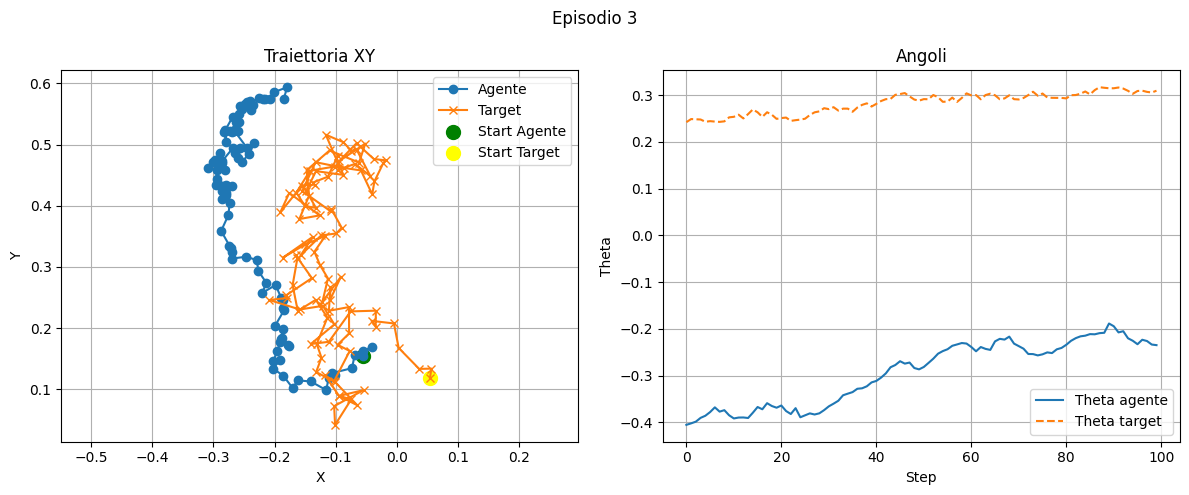

[Episodio 4] Passi attaccati: pos=0, ang=0, entrambi=0


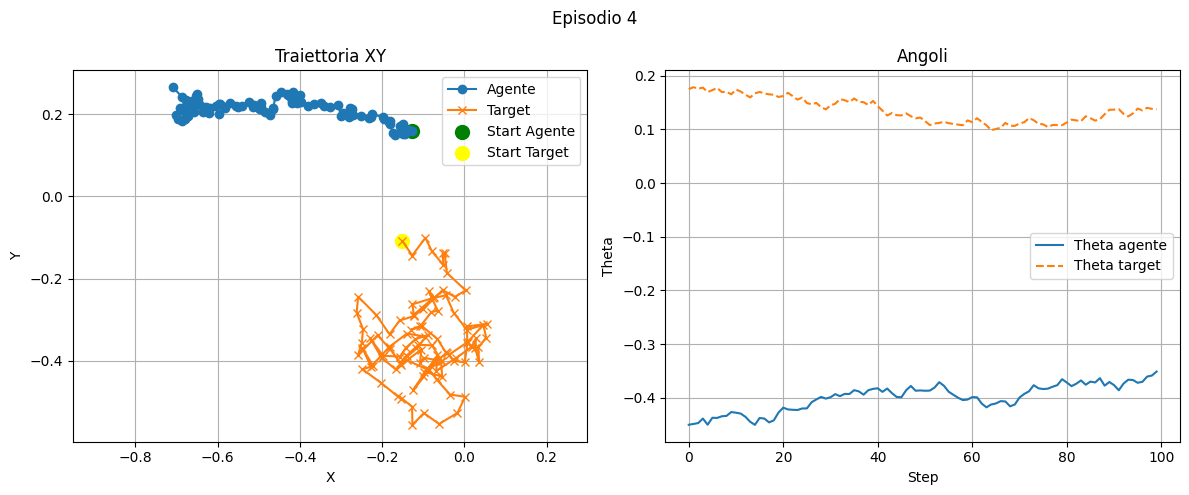


Risultati aggregati:
Media passi attaccati (traslazione): 0.20
Media passi attaccati (rotazione):    0.00
Media passi attaccati (entrambi):     0.00
Distanza media finale:                0.4692
Errore medio angolo finale:           0.5157


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from rototransl_env import TrackingEnv
from gail_transl import GaussianPolicy_transl
from gail_rot import GaussianPolicy_rot

def load_policies(path_transl="IL/bc_policy_transl.pth", path_rot="IL/bc_policy_rot.pth"):
    model_transl = GaussianPolicy_transl()  # [x, y, x_t, y_t] -> [dx, dy]
    model_rot = GaussianPolicy_rot()     # [theta, theta_t] -> [dtheta]
    model_transl.load_state_dict(torch.load(path_transl, map_location=torch.device("cpu")))
    model_rot.load_state_dict(torch.load(path_rot, map_location=torch.device("cpu")))
    model_transl.eval()
    model_rot.eval()
    return model_transl, model_rot

def test_bc_dual_policy(model_transl, model_rot, num_episodes=1000, tolerance_transl=0.02, tolerance_rot=0.01):
    env = TrackingEnv()

    total_attached = 0
    total_attached_transl = 0
    total_attached_rot = 0
    final_distances = []
    final_angle_errors = []

    for ep in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32)

        trajectory = []
        target_traj = []
        theta_traj = []
        theta_target_traj = []

        done = False
        total_attached_ep = 0
        total_attached_transl_ep = 0
        total_attached_rot_ep = 0

        while not done:
            trajectory.append(state[:2].numpy())
            target_traj.append(state[3:5].numpy())
            theta_traj.append(state[2].item())
            theta_target_traj.append(state[5].item())

            # Separa osservazioni
            obs_transl = torch.cat([state[:2], state[3:5]]).unsqueeze(0)  # [x, y, x_t, y_t]
            obs_rot = torch.stack([state[2], state[5]]).unsqueeze(0)      # [theta, theta_t]

            with torch.no_grad():
                dist_transl = model_transl(obs_transl)
                action_transl = dist_transl.sample().squeeze(0)
                dist_rot = model_rot(obs_rot)
                action_rot = dist_rot.sample().squeeze(0)

            # with torch.no_grad():
            #     action_transl = model_transl(obs_transl).squeeze()
            #     action_rot = model_rot(obs_rot).squeeze()

            action = torch.cat([action_transl, action_rot], dim=0).numpy()
            action = np.clip(action, env.action_space.low, env.action_space.high)

            next_state, _, done, truncated, _, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32)

            dist_transl = torch.norm(next_state[:2] - state[3:5])
            dist_rot = torch.abs(next_state[2] - state[5])

            if dist_transl < tolerance_transl:
                total_attached_transl_ep += 1
            if dist_rot < tolerance_rot:
                total_attached_rot_ep += 1
            if dist_transl < tolerance_transl and dist_rot < tolerance_rot:
                total_attached_ep += 1

            state = next_state
            done = truncated

        final_distances.append(dist_transl.item())
        final_angle_errors.append(dist_rot.item())
        total_attached += total_attached_ep
        total_attached_transl += total_attached_transl_ep
        total_attached_rot += total_attached_rot_ep

        print(f"[Episodio {ep}] Passi attaccati: pos={total_attached_transl_ep}, ang={total_attached_rot_ep}, entrambi={total_attached_ep}")
        if ep % 1 == 0:
            plot_trajectory(trajectory, target_traj, theta_traj, theta_target_traj, ep)

    env.close()

    print("\nRisultati aggregati:")
    print(f"Media passi attaccati (traslazione): {total_attached_transl / num_episodes:.2f}")
    print(f"Media passi attaccati (rotazione):    {total_attached_rot / num_episodes:.2f}")
    print(f"Media passi attaccati (entrambi):     {total_attached / num_episodes:.2f}")
    print(f"Distanza media finale:                {np.mean(final_distances):.4f}")
    print(f"Errore medio angolo finale:           {np.mean(final_angle_errors):.4f}")

def plot_trajectory(trajectory, target_traj, theta_traj, theta_target_traj, episode):
    trajectory = np.array(trajectory)
    target_traj = np.array(target_traj)
    theta_traj = np.array(theta_traj)
    theta_target_traj = np.array(theta_target_traj)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(trajectory[:, 0], trajectory[:, 1], marker='o', label="Agente")
    axs[0].plot(target_traj[:, 0], target_traj[:, 1], marker='x', label="Target")
    axs[0].scatter(trajectory[0, 0], trajectory[0, 1], color='green', label='Start Agente', s=100)
    axs[0].scatter(target_traj[0, 0], target_traj[0, 1], color='yellow', label='Start Target', s=100)
    axs[0].set_title("Traiettoria XY")
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].legend()
    axs[0].grid(True)
    axs[0].axis('equal')

    axs[1].plot(theta_traj, label="Theta agente")
    axs[1].plot(theta_target_traj, label="Theta target", linestyle='--')
    axs[1].set_title("Angoli")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("Theta")
    axs[1].legend()
    axs[1].grid(True)

    plt.suptitle(f"Episodio {episode}")
    plt.tight_layout()
    plt.show()
    plt.close()

# --- MAIN ---
if __name__ == "__main__":
    policy_transl, policy_rot = load_policies("IL/gail_policy_transl.pth", "IL/gail_policy_rot.pth")
    test_bc_dual_policy(policy_transl, policy_rot, num_episodes=5)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from torch.utils.data import DataLoader, TensorDataset
from ddpg_rot_dyn import DDPGAgent
from env_rot import TrackingEnv

# ==== DEFINIZIONE DEL MODELLO (es. MLP per continui) ====
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# ==== FUNZIONE DI TRAINING PER BEHAVIORAL CLONING ====
def train_model(model, observations, actions, epochs=10, batch_size=64):
    dataset = TensorDataset(torch.tensor(observations, dtype=torch.float32),
                            torch.tensor(actions, dtype=torch.float32))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        total_loss = 0
        for obs_batch, act_batch in dataloader:
            optimizer.zero_grad()
            predictions = model(obs_batch)
            loss = criterion(predictions, act_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# ==== LOOP PRINCIPALE DI DAGGER ====
def dagger(env, expert_model, agent_model, initial_obs, initial_act, iterations=1, episodes_per_iter=1):
    observations = list(initial_obs)
    actions = list(initial_act)

    # Tolleranze per comportamento "attached"
    tolerance_transl = 0.02
    tolerance_rot = 0.01

    # Allena il modello iniziale con BC
    print("[INFO] Inizio training BC iniziale")
    train_model(agent_model, observations, actions, epochs=1)

    # Inizia il loop DAgger
    for it in range(iterations):
        print(f"[INFO] Iterazione DAgger {it+1}/{iterations}")

        new_obs = []
        new_act = []

        for _ in range(episodes_per_iter):
            obs, _ = env.reset()
            print(obs)
            done = False
            attached_counter = 0
            episode_obs = []
            episode_act = []

            while not done:
                state = torch.tensor(obs, dtype=torch.float32)
                print(state)

                obs_tensor = state.unsqueeze(0)
                with torch.no_grad():
                    action = agent_model(obs_tensor).squeeze(0).numpy()
                next_obs, _, done, truncated, _ = env.step(action)
                next_state = torch.tensor(next_obs, dtype=torch.float32)
                done = truncated

                dist_transl = torch.norm(next_state[:2] - state[3:5])
                dist_rot = torch.abs(next_state[2] - state[5])

                if dist_transl < tolerance_transl and dist_rot < tolerance_rot:
                    attached_counter += 1

                with torch.no_grad():
                    expert_action = expert_model.actor(next_state.unsqueeze(0)).squeeze(0).numpy()

                episode_obs.append(next_obs)
                episode_act.append(expert_action)

                obs = next_obs

            # Considera l'episodio valido solo se almeno 90 step "attached"
            if attached_counter >= 90:
                print("[INFO] Episodio valido con attached_counter:", attached_counter, "dataset aumentato.")
                new_obs.extend(episode_obs)
                new_act.extend(episode_act)

        # Aggrega i nuovi dati
        observations.extend(new_obs)
        actions.extend(new_act)

        # Ri-allena il modello
        train_model(agent_model, observations, actions, epochs=10)

    # Salva il modello finale
    torch.save(agent_model.state_dict(), "IL/dagger_model_rot_0.5_0.01.pth")
    print("[INFO] Modello DAgger salvato.")

def load_agents(checkpoint_path_rot, env=None):
    if env is None:
        env = TrackingEnv()

    state_dim_rot = 2    # theta, theta_target

    agent_rot = DDPGAgent(state_dim_rot, 1)

    ckpt_rot = torch.load(checkpoint_path_rot, map_location=torch.device('cpu'))

    agent_rot.actor.load_state_dict(ckpt_rot['actor_state_dict'])

    return agent_rot

# ==== ESECUZIONE ====
if __name__ == "__main__":

    # Parametri dell'ambiente
    input_dim = 2    # Modifica per rotazione (es. 2) o traslazione (es. 4)
    output_dim = 1   # Modifica per rotazione (es. 1) o traslazione (es. 2)

    # Istanzia ambiente ed esperto
    env = TrackingEnv()

    expert_model = load_agents("Rotazioni-dinamiche/No-noise/ddpg_mov_0.01_20250509_163508/checkpoint_ep782.pth", env)
    expert_model.actor.eval()

    agent_model = PolicyNetwork(input_dim, output_dim)

    # Carica dati esperti
    expert_data = np.load("trajectories/dataset_rot.npz")
    initial_obs = expert_data['observations']
    initial_act = expert_data['actions']

    dagger(env, expert_model, agent_model, initial_obs, initial_act, iterations=10, episodes_per_iter=5)


[INFO] Inizio training BC iniziale


/var/folders/72/24j7jy9s6sb2xm_dc84kdhm00000gn/T/ipykernel_7285/1016217631.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  dataset = TensorDataset(torch.tensor(observations, dtype=torch.float32),


Epoch 1, Loss: 432.9794
[INFO] Iterazione DAgger 1/10
[ 0.23199394 -0.34400548]
tensor([ 0.2320, -0.3440])


ValueError: too many values to unpack (expected 4)